## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

In [1]:
from google.colab import drive
def mount_drive():
  drive.mount('/content/gdrive')
mount_drive()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Importing the necessary libraries

In [2]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk import word_tokenize

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('punkt_tab')

from collections import Counter
from wordcloud import WordCloud
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file
f = "/content/gdrive/MyDrive/sample_data_to_delete/complaints-2021-05-14_08_16.json" # Write the path to your data file and load it
with open(f, 'r') as f:
# returns JSON object as
# a dictionary
  data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

print("Shape of the dataset:", df.shape)
print(df.head())

Shape of the dataset: (78313, 22)
                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \


In [5]:
#print the column names

print(df.columns.tolist())

['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [6]:
#Assign new column names
df.rename(columns={
    "_index": "index",
    "_type": "type",
    "_id": "id",
    "_score": "score",
    "_source.tags": "tags",
    "_source.zip_code": "zip_code",
    "_source.complaint_id": "complaint_id",
    "_source.issue": "issue",
    "_source.date_received": "date_received",
    "_source.state": "state",
    "_source.consumer_disputed": "consumer_disputed",
    "_source.product": "product",
    "_source.company_response": "company_response",
    "_source.company": "company",
    "_source.submitted_via": "submitted_via",
    "_source.date_sent_to_company": "date_sent_to_company",
    "_source.company_public_response": "company_public_response",
    "_source.sub_product": "sub_product",
    "_source.timely": "timely",
    "_source.complaint_what_happened": "complaint_what_happened",
    "_source.sub_issue": "sub_issue",
    "_source.consumer_consent_provided": "consumer_consent_provided"
}, inplace=True)

#confirm columns after renaming
print(df.columns.tolist())

['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [7]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)

In [8]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

# Confirm result
print("Remaining rows:", len(df))

Remaining rows: 21072


In [10]:
# Creating it for later reference
training_data_new = df.copy()
training_data_new["complaints"] = training_data_new["complaint_what_happened"]

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
    cleaned_text = text.strip() # Remove leading/trailing whitespace

    # Step 1: Make the text lowercase
    cleaned_text = cleaned_text.lower()

    # Step 2: Remove text in square brackets
    cleaned_text = re.sub(r'\[.*?\]', '', cleaned_text)

    # Step 3: Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    cleaned_text = cleaned_text.translate(translator)

    # Step 4: Remove words containing numbers
    # \b matches word boundary, \w* matches zero or more word characters, \d matches a digit
    cleaned_text = re.sub(r'\b\w*\d\w*\b', '', cleaned_text)
    # After removing words, there might be extra spaces, so strip and replace multiple spaces
    cleaned_text = cleaned_text.strip()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    return cleaned_text



In [12]:
#Write your function to Lemmatize the texts
def lematize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)


In [13]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df['complaints'] = df['complaint_what_happened'].apply(clean_data)
df['lematize_complaints'] = df['complaints'].apply(lematize_text)
df_clean = df[["complaints", "lematize_complaints"]]

In [14]:
df_clean

,complaints,lematize_complaints
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent did upgrade...
10,chase card was reported on however fraudulent ...,chase card reported fraudulent application sub...
11,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came offer applie...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offered multiple so...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay did understand great risk pr...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...


In [15]:
#Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
  tokens = nltk.word_tokenize(text)
  return nltk.pos_tag(tokens)

# df_clean["pos_tag"] = df_clean["lematize_complaints"].apply(pos_tag)
# print(df_clean["pos_tag"].head())
# print(df_clean["complaint_POS_removed"]) =  df_clean["pos_tag"].apply(lambda x: ' '.join([word for word, tag in x if tag == "NN"]))
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean["lematize_complaints"].apply(pos_tag).apply(lambda x: ' '.join([word for word, tag in x if tag == "NN"]))


<ipython-input-15-b1f574780109>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
#df_clean["complaint_POS_removed"]
df_clean.head()

,complaints,lematize_complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning xxxx appreciate help chase bank cardme...
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent did upgrade...,xxxx card agent anniversary date change inform...
10,chase card was reported on however fraudulent ...,chase card reported fraudulent application sub...,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came offer applie...,book ticket offer ticket information offer min...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund chase bank acco...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




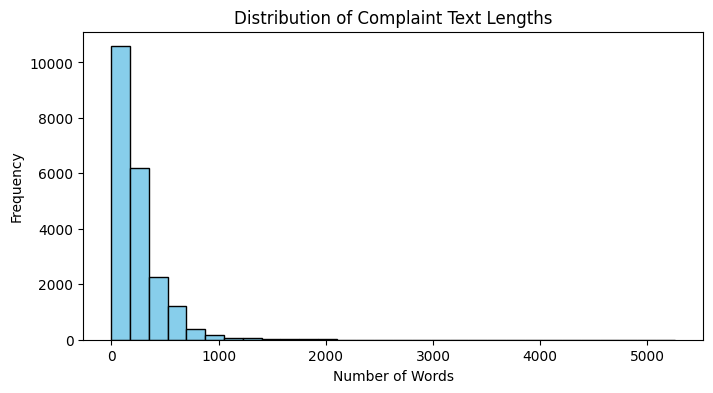

In [17]:
# Write your code here to visualise the data according to the 'Complaint' character length
df['text_length'] = df_clean['complaints'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
plt.hist(df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Complaint Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

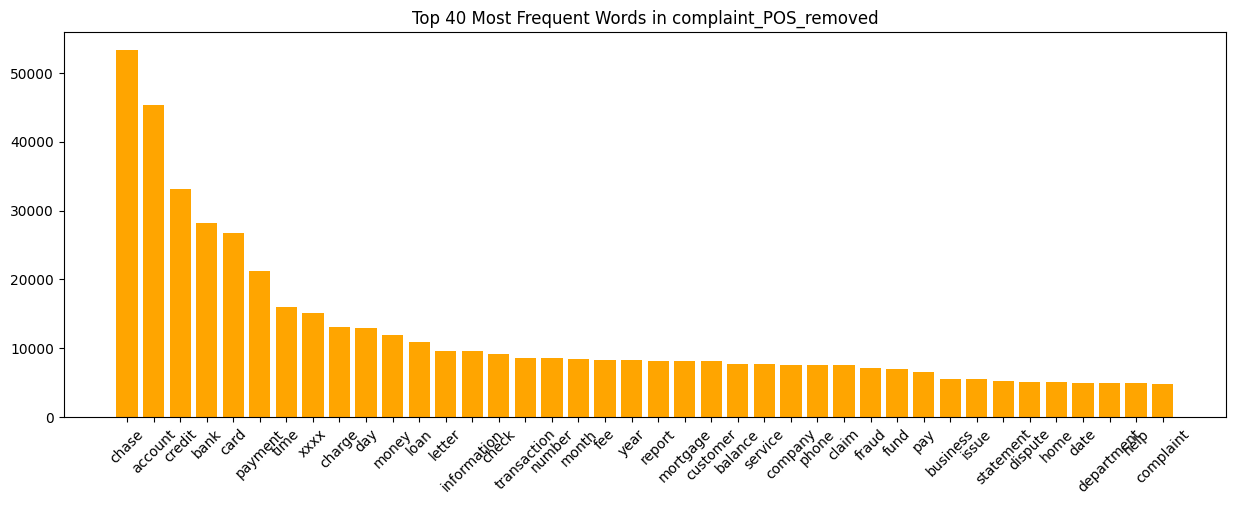

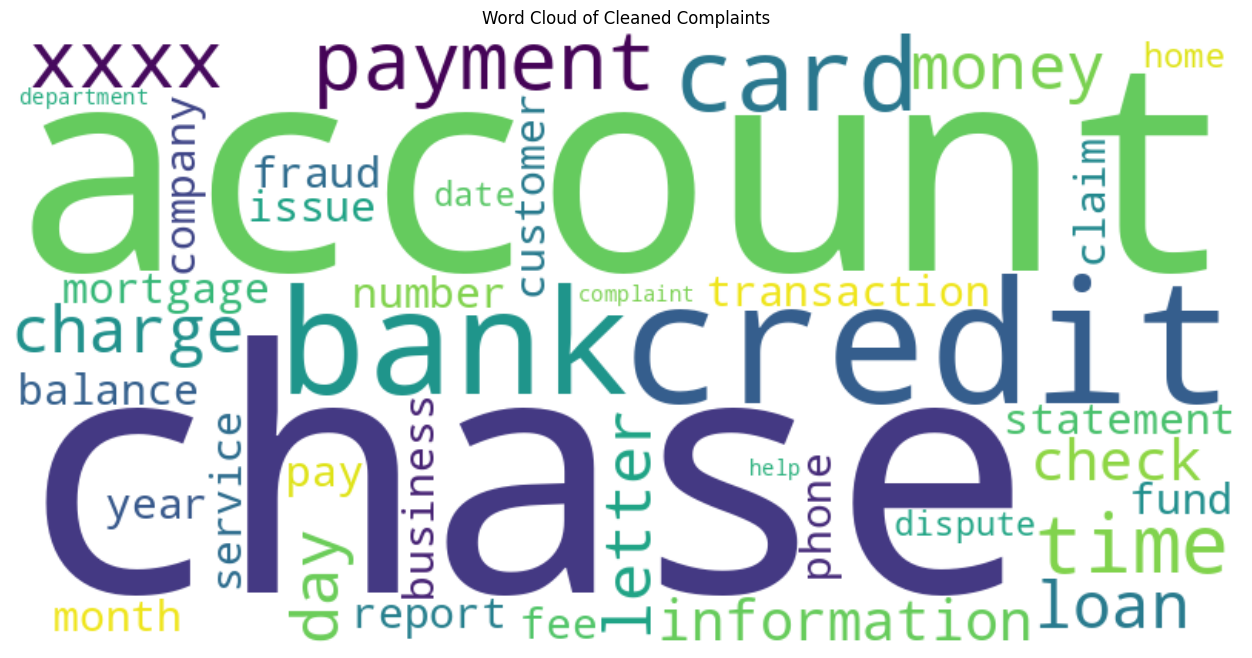

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text


all_words = ' '.join(df_clean["complaint_POS_removed"]).split()
common_words = Counter(all_words).most_common(40)

# Plot common words
words, counts = zip(*common_words)
plt.figure(figsize=(15, 5))
plt.bar(words, counts, color='orange')
plt.xticks(rotation=45)
plt.title(f'Top 40 Most Frequent Words in complaint_POS_removed')
plt.show()

wordcloud_data = {word: freq for word, freq in common_words}
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(' '.join(wordcloud_data))
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Complaints')
plt.show()



In [19]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

<ipython-input-19-2ee47e6ecbae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

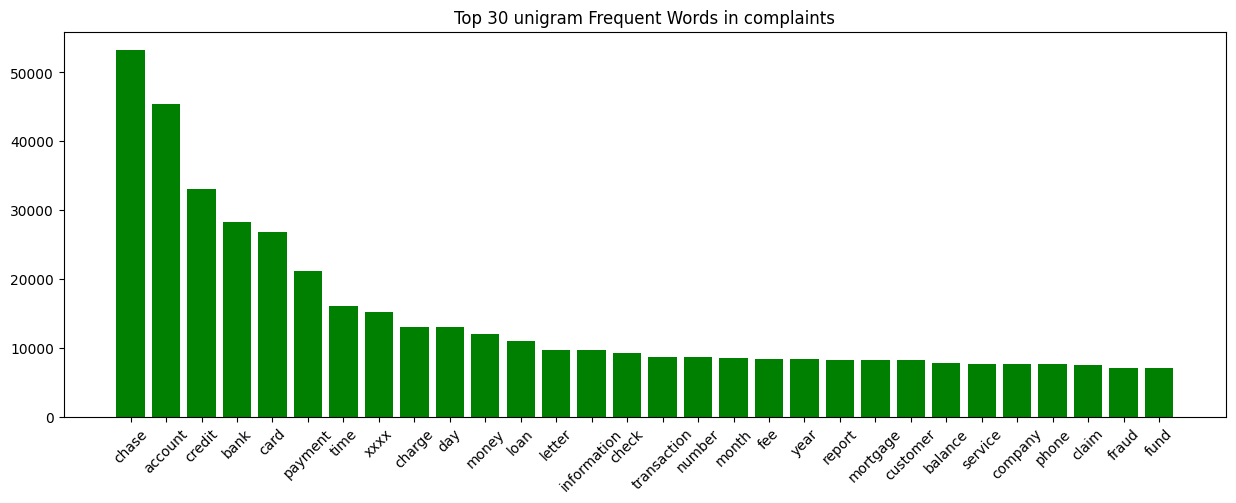

In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
all_unigrams = ' '.join(df_clean['Complaint_clean']).split()
unigram_counts = Counter(all_unigrams)
top_unigrams = unigram_counts.most_common(30)

# Plot common words
words, counts = zip(*top_unigrams)
plt.figure(figsize=(15, 5))
plt.bar(words, counts, color='green')
plt.xticks(rotation=45)
plt.title(f'Top 30 unigram Frequent Words in complaints')
plt.show()

In [21]:
#Print the top 10 words in the unigram

all_unigrams = ' '.join(df_clean['Complaint_clean']).split()
unigram_counts = Counter(all_unigrams)
top_unigrams = unigram_counts.most_common(10)
print(top_unigrams)

[('chase', 53249), ('account', 45400), ('credit', 33094), ('bank', 28233), ('card', 26802), ('payment', 21167), ('time', 16038), ('xxxx', 15192), ('charge', 13039), ('day', 12972)]


<ipython-input-22-c3915739a2eb>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




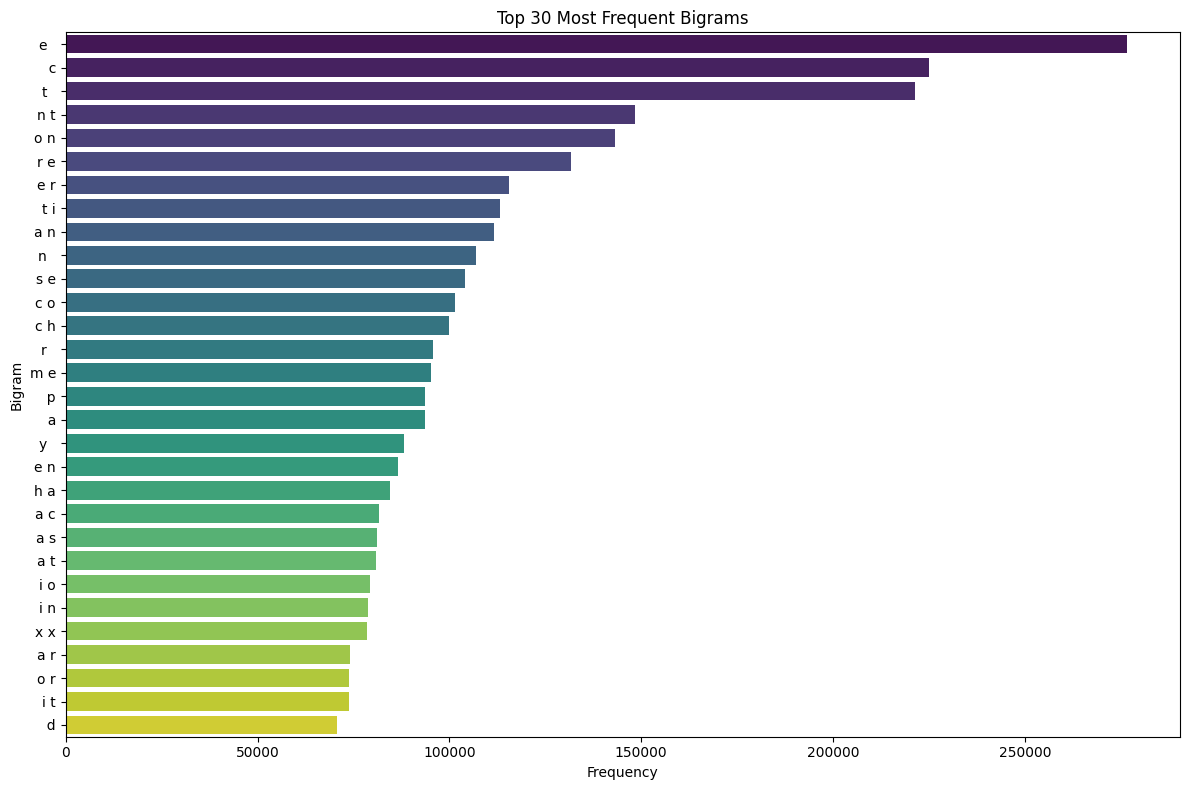

In [22]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
all_bigrams = []
for tokens in df_clean['Complaint_clean']:
    all_bigrams.extend(list(ngrams(tokens, 2)))
bigram_frequencies = Counter(all_bigrams)
top_30_bigrams = bigram_frequencies.most_common(30)

bigram_labels = [" ".join(bigram) for bigram, freq in top_30_bigrams]
bigram_counts = [freq for bigram, freq in top_30_bigrams]

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=bigram_counts, y=bigram_labels, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Top 30 Most Frequent Bigrams')
plt.tight_layout()
plt.show()



In [23]:
#Print the top 10 words in the bigram frequency
all_bigrams = []
for tokens in df_clean['Complaint_clean']:
    all_bigrams.extend(list(ngrams(tokens, 2)))
bigram_frequencies = Counter(all_bigrams)
top_10_bigrams = bigram_frequencies.most_common(10)
print(top_10_bigrams)

[(('e', ' '), 276591), ((' ', 'c'), 224883), (('t', ' '), 221298), (('n', 't'), 148296), (('o', 'n'), 143215), (('r', 'e'), 131620), (('e', 'r'), 115577), (('t', 'i'), 113073), (('a', 'n'), 111727), (('n', ' '), 107042)]


<ipython-input-24-8e21b1492e0f>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




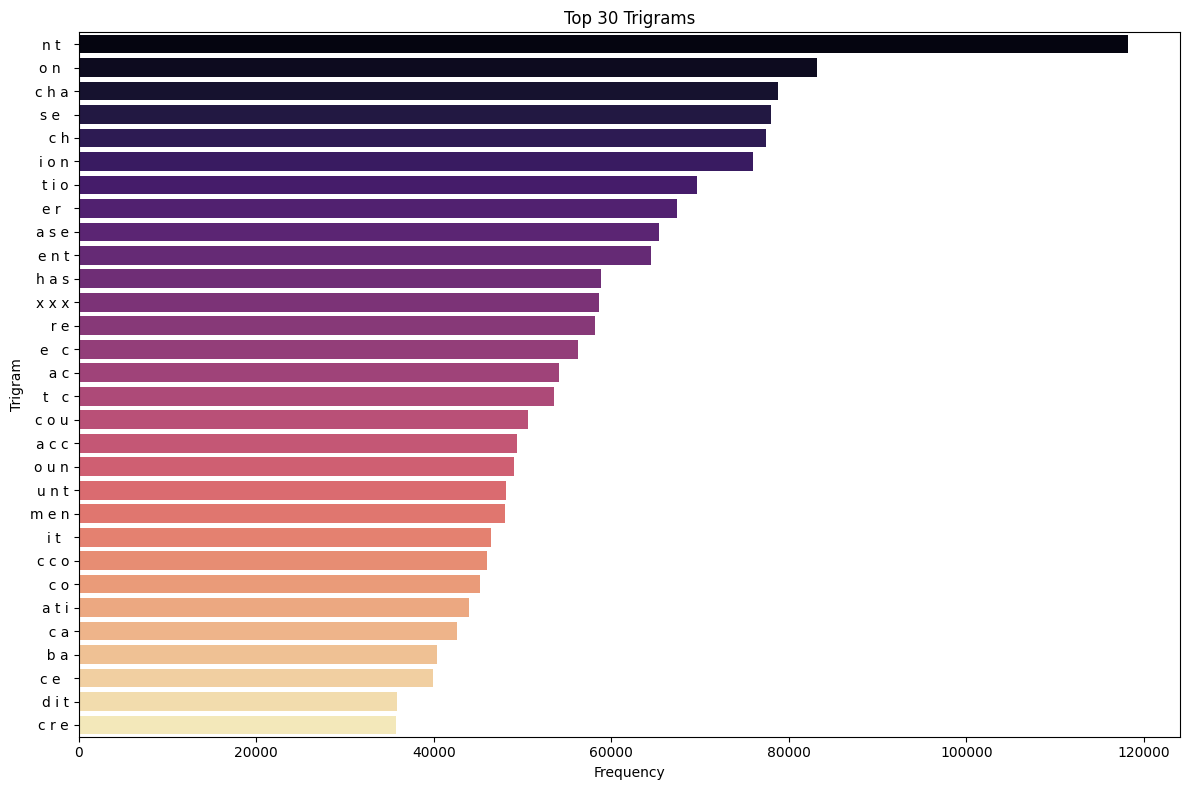

In [24]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
all_trigrams = []
for tokens in df_clean['Complaint_clean']:
    all_trigrams.extend(list(ngrams(tokens, 3)))
trigram_frequencies = Counter(all_trigrams)
top_30_trigrams = trigram_frequencies.most_common(30)


# Prepare data for plotting
trigram_labels = [" ".join(trigram) for trigram, freq in top_30_trigrams]
trigram_counts = [freq for trigram, freq in top_30_trigrams]

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=trigram_counts, y=trigram_labels, palette='magma')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.title('Top 30 Trigrams')
plt.tight_layout()
plt.show()


In [25]:
#Print the top 10 words in the trigram frequency
all_trigrams = []
for tokens in df_clean['Complaint_clean']:
    all_trigrams.extend(list(ngrams(tokens, 3)))
trigram_frequencies = Counter(all_trigrams)
top_10_trigrams = trigram_frequencies.most_common(10)
print(top_10_trigrams)

[(('n', 't', ' '), 118165), (('o', 'n', ' '), 83217), (('c', 'h', 'a'), 78811), (('s', 'e', ' '), 77998), ((' ', 'c', 'h'), 77399), (('i', 'o', 'n'), 75956), (('t', 'i', 'o'), 69665), (('e', 'r', ' '), 67410), (('a', 's', 'e'), 65407), (('e', 'n', 't'), 64502)]


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [26]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

<ipython-input-26-d4beb8194a2f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
#All masked texts has been removed
df_clean

,complaints,lematize_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning xxxx appreciate help chase bank cardme...,morning appreciate help chase bank cardmember...
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent did upgrade...,xxxx card agent anniversary date change inform...,card agent anniversary date change informatio...
10,chase card was reported on however fraudulent ...,chase card reported fraudulent application sub...,chase card application identity consent servic...,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came offer applie...,book ticket offer ticket information offer min...,book ticket offer ticket information offer min...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offered multiple so...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday chas xxxx credit card provider claim...,wednesday chas credit card provider claim pur...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay did understand great risk pr...,pay risk consumer chase bank year trust deal m...,pay risk consumer chase bank year trust deal m...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,flawless credit chase credit card chase freedo...,flawless credit chase credit card chase freedo...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [28]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [29]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
print(f"TF-IDF matrix shape: {dtm.shape}")

TF-IDF matrix shape: (21072, 7026)


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [30]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [31]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [32]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7026

In [33]:
#Print the Top15 words for each of the topics
tfidf_feature_names = tfidf.get_feature_names_out()
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        # Sort words by their weight in the topic and get top N
        top_words_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_indices]
        print(f"  {', '.join(top_words)}")

print_top_words(nmf_model, tfidf_feature_names, 15)

Topic 1:
  account, bank, check, money, chase, fund, deposit, day, branch, number, business, transaction, transfer, customer, claim
Topic 2:
  credit, card, report, inquiry, chase, account, score, company, bureau, limit, debt, information, application, letter, year
Topic 3:
  loan, mortgage, home, chase, modification, property, year, rate, letter, time, bank, house, foreclosure, sale, document
Topic 4:
  charge, chase, card, transaction, dispute, fraud, fee, merchant, claim, purchase, service, time, statement, refund, phone
Topic 5:
  payment, balance, month, fee, statement, pay, day, time, chase, date, auto, credit, year, mortgage, car


In [34]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

best_topics = nmf_model.transform(dtm)

In [35]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = best_topics.argmax(axis=1) #write your code to assign topics to each rows.

<ipython-input-35-30aef8b023b5>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
df_clean.head()

,complaints,lematize_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning xxxx appreciate help chase bank cardme...,morning appreciate help chase bank cardmember...,0
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent did upgrade...,xxxx card agent anniversary date change inform...,card agent anniversary date change informatio...,1
10,chase card was reported on however fraudulent ...,chase card reported fraudulent application sub...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came offer applie...,book ticket offer ticket information offer min...,book ticket offer ticket information offer min...,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0


In [37]:
#Print the first 5 Complaint for each of the Topics
df_clean_first=df_clean.groupby('Topic').head(5)
df_clean_first.sort_values('Topic')

,complaints,lematize_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning xxxx appreciate help chase bank cardme...,morning appreciate help chase bank cardmember...,0
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,jp chase account debit card tuesday branch cus...,jp chase account debit card tuesday branch cus...,0
27,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account bank code bonus xxxxxxxx term account ...,account bank code bonus term account deposit ...,0
24,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account auto xxxx,account auto,0
10,chase card was reported on however fraudulent ...,chase card reported fraudulent application sub...,chase card application identity consent servic...,chase card application identity consent servic...,1
11,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came offer applie...,book ticket offer ticket information offer min...,book ticket offer ticket information offer min...,1
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent did upgrade...,xxxx card agent anniversary date change inform...,card agent anniversary date change informatio...,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card credit report company issue,chase credit card credit report company issue,1
15,can you please remove inquiry,remove inquiry,inquiry,inquiry,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [38]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Credit card / Prepaid card',
    1: 'Bank account services',
    2: 'Theft/Dispute reporting',
    3: 'Mortgages/loans',
    4: 'Others'
  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-38-f3503357acbf>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
df_clean

,complaints,lematize_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning xxxx appreciate help chase bank cardme...,morning appreciate help chase bank cardmember...,Credit card / Prepaid card
2,i upgraded my xxxx xxxx card in and was told b...,upgraded xxxx xxxx card told agent did upgrade...,xxxx card agent anniversary date change inform...,card agent anniversary date change informatio...,Bank account services
10,chase card was reported on however fraudulent ...,chase card reported fraudulent application sub...,chase card application identity consent servic...,chase card application identity consent servic...,Bank account services
11,on while trying to book a xxxx xxxx ticket i c...,trying book xxxx xxxx ticket came offer applie...,book ticket offer ticket information offer min...,book ticket offer ticket information offer min...,Bank account services
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,Credit card / Prepaid card
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offered multiple so...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Bank account services
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday chas xxxx credit card provider claim...,wednesday chas credit card provider claim pur...,Mortgages/loans
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay did understand great risk pr...,pay risk consumer chase bank year trust deal m...,pay risk consumer chase bank year trust deal m...,Mortgages/loans
78311,i have had flawless credit for yrs ive had cha...,flawless credit yr ive chase credit card chase...,flawless credit chase credit card chase freedo...,flawless credit chase credit card chase freedo...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [40]:
### Note - Already done this step just in the above step so not needed!!
#Create the dictionary again of Topic names and Topics

Topic_names = {
    0: 'Credit card / Prepaid card',
    1: 'Bank account services',
    2: 'Theft/Dispute reporting',
    3: 'Mortgages/loans',
    4: 'Others'
  }
#Replace Topics with Topic Names -
#df_clean['Topic'] = df_clean['Topic'].map(Topic_names)
print(df_clean['Topic'].value_counts())

Topic
Credit card / Prepaid card    5337
Bank account services         4974
Mortgages/loans               4734
Theft/Dispute reporting       3637
Others                        2390
Name: count, dtype: int64


In [42]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['Complaint_clean', 'Topic']]
training_data.rename(columns={"Complaint_clean": "complaint_what_happened"}, inplace=True)


<ipython-input-42-e3ec6d745906>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
training_data.head()

,complaint_what_happened,Topic
1,morning appreciate help chase bank cardmember...,Credit card / Prepaid card
2,card agent anniversary date change informatio...,Bank account services
10,chase card application identity consent servic...,Bank account services
11,book ticket offer ticket information offer min...,Bank account services
14,son deposit chase account fund chase bank acco...,Credit card / Prepaid card


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [44]:
# forming dataframe to compare it at the last with original complaints
df_actual_clean = pd.concat([training_data_new[["complaints"]], training_data[["complaint_what_happened", "Topic"]]], axis=1)

                                           complaints  \
1   Good morning my name is XXXX XXXX and I apprec...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10  Chase Card was reported on XX/XX/2019. However...   
11  On XX/XX/2018, while trying to book a XXXX  XX...   
14  my grand son give me check for {$1600.00} i de...   

                              complaint_what_happened  \
1   morning  appreciate help chase bank cardmember...   
2    card agent anniversary date change informatio...   
10  chase card application identity consent servic...   
11  book ticket offer ticket information offer min...   
14  son deposit chase account fund chase bank acco...   

                         Topic  
1   Credit card / Prepaid card  
2        Bank account services  
10       Bank account services  
11       Bank account services  
14  Credit card / Prepaid card  


In [55]:

#Write your code to get the Vector count

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df_actual_clean['complaint_what_happened'])


#Write your code here to transform the word vector to tf-idf

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)



X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_actual_clean['Topic'], test_size=0.2, random_state=42)

# X_train, y_train: for training the model
# X_test, y_test: for evaluating the model

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (16857, 15128)
Test shape: (4215, 15128)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

Classification Report:

                            precision    recall  f1-score   support

     Bank account services       0.97      0.97      0.97      1033
Credit card / Prepaid card       0.96      0.97      0.96      1091
           Mortgages/loans       0.95      0.97      0.96       925
                    Others       0.98      0.92      0.95       484
   Theft/Dispute reporting       0.96      0.98      0.97       682

                  accuracy                           0.96      4215
                 macro avg       0.97      0.96      0.96      4215
              weighted avg       0.96      0.96      0.96      4215



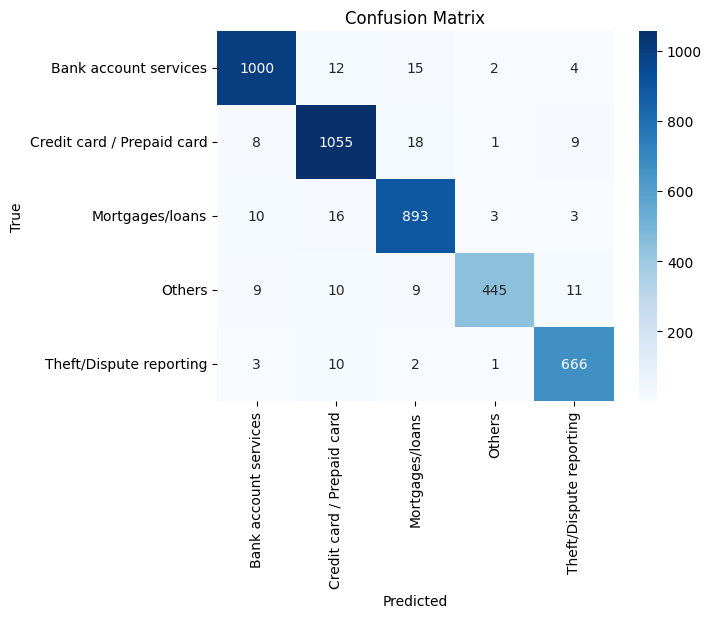

In [56]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# MODEL:1 Train the  using LogisticRegression
lgclf = LogisticRegression(max_iter=1000, random_state=42)
lgclf.fit(X_train, y_train)


# Predictions
y_pred = lgclf.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=lgclf.classes_)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=lgclf.classes_, yticklabels=lgclf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Classification Report (Decision Tree):

                            precision    recall  f1-score   support

     Bank account services       0.83      0.88      0.86      1033
Credit card / Prepaid card       0.85      0.83      0.84      1091
           Mortgages/loans       0.74      0.79      0.76       925
                    Others       0.84      0.80      0.82       484
   Theft/Dispute reporting       0.88      0.79      0.84       682

                  accuracy                           0.83      4215
                 macro avg       0.83      0.82      0.82      4215
              weighted avg       0.83      0.83      0.83      4215



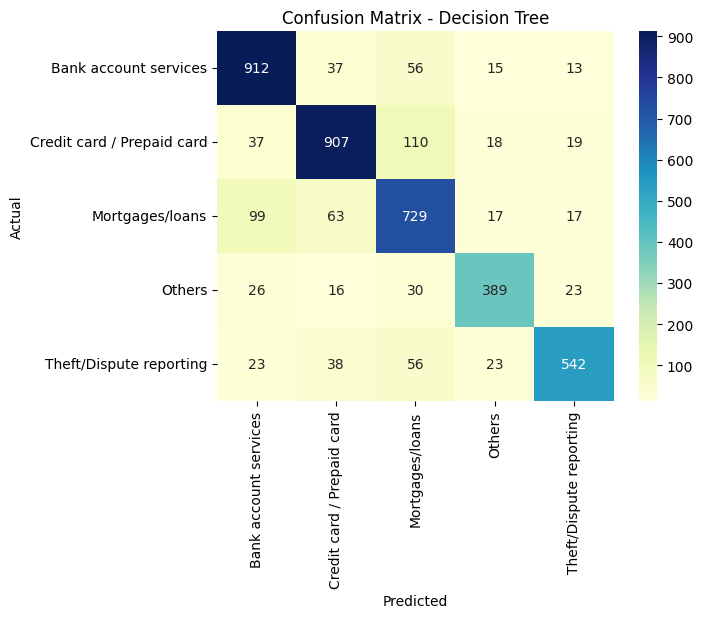

In [57]:
# MODEL:2 Train the  using Decision Tree

dt_clf = DecisionTreeClassifier(random_state=42, max_depth=20)
dt_clf.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = dt_clf.predict(X_test)

# Step 5: Evaluate performance
print("Classification Report (Decision Tree):\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=dt_clf.classes_)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=dt_clf.classes_, yticklabels=dt_clf.classes_, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

Classification Report (Random Forest):

                            precision    recall  f1-score   support

     Bank account services       0.77      0.91      0.83      1033
Credit card / Prepaid card       0.78      0.92      0.85      1091
           Mortgages/loans       0.84      0.79      0.82       925
                    Others       0.97      0.34      0.50       484
   Theft/Dispute reporting       0.87      0.87      0.87       682

                  accuracy                           0.81      4215
                 macro avg       0.85      0.77      0.77      4215
              weighted avg       0.83      0.81      0.80      4215



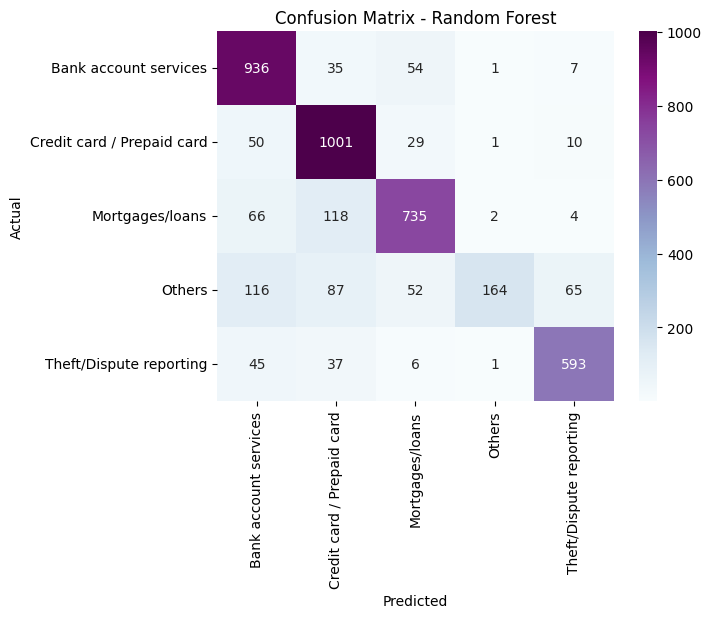

In [58]:
# MODEL:3 Train the  using Random Forest

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42)
rf_clf.fit(X_train, y_train)

# Step 4: Predict
y_pred = rf_clf.predict(X_test)

# Step 5: Evaluate
print("Classification Report (Random Forest):\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_, cmap='BuPu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Model Inference

In [59]:
# Model performance

def predict_complaint(index, model_name, df, models):

    # Validate model name
    if model_name not in models:
        print(f"Invalid model name: {model_name}. Choose from: {list(models.keys())}")
        return

    model = models[model_name]

    # Get input data
    try:
        cleaned_text = df['complaint_what_happened'].iloc[index]
        original_complaint = df['complaints'].iloc[index]
        actual_topic = df['Topic'].iloc[index]
    except IndexError:
        print(f"Index {index} is out of range.")
        return

    # Transform the text using trained TF-IDF vectorizer
    X_counts_new = count_vect.transform([cleaned_text])
    X_tfidf_new = tfidf_transformer.transform(X_counts_new)

    # Predict
    predicted_topic = model.predict(X_tfidf_new)[0]

    # Output
    print(f"\n--- Model: {model_name.replace('_', ' ').title()} ---")
    print(f"Original Complaint:\n{original_complaint}\n")
    print(f"Cleaned Text:\n{cleaned_text}\n")
    print(f"Actual Topic   : {actual_topic}")
    print(f"Predicted Topic: {predicted_topic}")


In [60]:
models = {
    'logistic': lgclf,
    'decision_tree': dt_clf,
    'random_forest': rf_clf
}

In [61]:
#Predict using Random Forest on row 501
predict_complaint(index=799, model_name='random_forest', df=df_actual_clean, models=models)


--- Model: Random Forest ---
Original Complaint:
On XX/XX/XXXX I called and spoke with chase auto fiance Account number XXXX, I explained that I had called and requested a billing extension for one month which was granted ; but do to my health and being in and out of the hospital I would need another 3 month extension, I was told they could not do another extension, however they could change the due date from the XXXX of the month to the XXXX. I was also told that f that payment was not received or was returned that the original due date would revert back to the XXXX. Because I didnt receive any statements after s I was in the hospital. I called back and explained this to an agent, who because I hadnt received the statements informed me because it was a medical emergency do to a XXXX XXXX that she would submit XXXX late fees in the amount of {$30.00} each to be reviewed to be removed. I then spoke with a supervisor, her name was XXXX id XXXX making a payment at chase bank I called bac

In [62]:
#Predict using Logistic Regression
predict_complaint(index=799, model_name='logistic', df=df_actual_clean, models=models)


--- Model: Logistic ---
Original Complaint:
On XX/XX/XXXX I called and spoke with chase auto fiance Account number XXXX, I explained that I had called and requested a billing extension for one month which was granted ; but do to my health and being in and out of the hospital I would need another 3 month extension, I was told they could not do another extension, however they could change the due date from the XXXX of the month to the XXXX. I was also told that f that payment was not received or was returned that the original due date would revert back to the XXXX. Because I didnt receive any statements after s I was in the hospital. I called back and explained this to an agent, who because I hadnt received the statements informed me because it was a medical emergency do to a XXXX XXXX that she would submit XXXX late fees in the amount of {$30.00} each to be reviewed to be removed. I then spoke with a supervisor, her name was XXXX id XXXX making a payment at chase bank I called back and

In [63]:
#Predict using Decision Tree
predict_complaint(index=799, model_name='decision_tree', df=df_actual_clean, models=models)


--- Model: Decision Tree ---
Original Complaint:
On XX/XX/XXXX I called and spoke with chase auto fiance Account number XXXX, I explained that I had called and requested a billing extension for one month which was granted ; but do to my health and being in and out of the hospital I would need another 3 month extension, I was told they could not do another extension, however they could change the due date from the XXXX of the month to the XXXX. I was also told that f that payment was not received or was returned that the original due date would revert back to the XXXX. Because I didnt receive any statements after s I was in the hospital. I called back and explained this to an agent, who because I hadnt received the statements informed me because it was a medical emergency do to a XXXX XXXX that she would submit XXXX late fees in the amount of {$30.00} each to be reviewed to be removed. I then spoke with a supervisor, her name was XXXX id XXXX making a payment at chase bank I called bac

In [65]:
# Best Model based on accuracy and F1 score
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')  # Macro for balanced class representation

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'F1 Score': round(f1, 4)
    })

# Create DataFrame with results
performance_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)

# Display the results
print("Model Performance Summary:\n")
print(performance_df.to_string(index=False))

Model Performance Summary:

        Model  Accuracy  F1 Score
     logistic    0.9630    0.9620
decision_tree    0.8254    0.8246
random_forest    0.8135    0.7737
